# This ML script would not have been possible without inspiration from, github user ***'wiamsuri'*** and their project ***'cnn-image-classifier-keras'***

In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
# from PIL import ImageFile
import random
from tqdm import tqdm
from keras.preprocessing import image
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from skimage.transform import resize
import os
import pandas as pd

# Load Images From File

In [2]:
image_names = [item.replace('resources/data_for_training_05/', '') for item in sorted(glob("resources/data_for_training_05/*/"))]
number_of_image_categories = len(image_names)
print('%d image categories.' % number_of_image_categories)
print('Three categories:')
print(image_names[:3])

3 image categories.
Three categories:
['brick_10/', 'siding_20/', 'unknown_00/']


In [3]:
def load_dataset(path):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    image_targets = np_utils.to_categorical(np.array(data['target']), number_of_image_categories)
    return image_files, image_targets


image_files, image_targets = load_dataset('resources/data_for_training_05/')

trains_validate_files, test_files, trains_validate_targets, test_targets = \
    train_test_split(image_files, image_targets, test_size=0.2, random_state=42)

train_files, valid_files, train_targets, valid_targets = \
    train_test_split(trains_validate_files, trains_validate_targets, test_size=0.25, random_state=42)

image_names = [item[20:-1] for item in sorted(glob("resources/data_for_training_05/*/"))]

print('%s images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('%d training images.' % len(train_files))
print('%d validation images.' % len(valid_files))
print('%d test images.'% len(test_files))

3915 images.

2349 training images.
783 validation images.
783 test images.


# Define function for preprocessing images

In [4]:
def path_to_tensor(img_path):

    img = image.load_img(img_path, grayscale=False, color_mode="rgb", target_size=(400, 400), interpolation="nearest")
    img_array = image.img_to_array(img)

    return np.expand_dims(img_array, axis=0)

def paths_to_tensor(img_paths):
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# Preprocess images

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 783/783 [00:10<00:00, 76.29it/s]


# Build Model

In [6]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=2, padding='same',
                 activation='relu', input_shape=(400, 400, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))



model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))


model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 400, 400, 4)       52        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 200, 200, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 8)       136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 12)      396       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 12)        0

# Train the model with training and validating images

In [7]:
epochs = 15

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.image_classifier.hdf5',
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

Epoch 1/15
37/37 [==============================] - ETA: 0s - loss: 1.7325 - accuracy: 0.4321
Epoch 00001: val_loss improved from inf to 1.01546, saving model to saved_models/weights.best.image_classifier.hdf5
37/37 [==============================] - 147s 4s/step - loss: 1.7325 - accuracy: 0.4321 - val_loss: 1.0155 - val_accuracy: 0.5990
Epoch 2/15
37/37 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.5143
Epoch 00002: val_loss did not improve from 1.01546
37/37 [==============================] - 102s 3s/step - loss: 0.9744 - accuracy: 0.5143 - val_loss: 1.0240 - val_accuracy: 0.5773
Epoch 3/15
37/37 [==============================] - ETA: 0s - loss: 0.9368 - accuracy: 0.5517
Epoch 00003: val_loss did not improve from 1.01546
37/37 [==============================] - 107s 3s/step - loss: 0.9368 - accuracy: 0.5517 - val_loss: 1.0259 - val_accuracy: 0.5785
Epoch 4/15
37/37 [==============================] - ETA: 0s - loss: 0.8972 - accuracy: 0.5896
Epoch 00004: val

In [8]:
model.load_weights('saved_models/weights.best.image_classifier.hdf5')

predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 76.8838%


In [9]:
for image in os.listdir('test_imgs'):
    img = plt.imread('test_imgs' + '/' + image)
    resized_image = resize(img, (400,400,3))
    predictions = model.predict(np.array([resized_image]))
#     print(f'{image}:\t {predictions}')
    print(f'{image}:\t {round(100 * predictions[0][0])}%')

_6672.jpg:	 57.0%
_6673.jpg:	 75.0%
_81.jpg:	 62.0%
_7581.jpg:	 66.0%
_6675.jpg:	 84.0%
_6449.jpg:	 39.0%
_7839.jpg:	 53.0%
_7493.jpg:	 74.0%
_7135.jpg:	 71.0%
_5901.jpg:	 33.0%
_6819.jpg:	 77.0%
_5902.jpg:	 55.0%
_7494.jpg:	 73.0%
_7669.jpg:	 58.0%
_7664.jpg:	 56.0%
_7266.jpg:	 90.0%
_7488.jpg:	 76.0%
_7271.jpg:	 45.0%
_62.jpg:	 76.0%
_6450.jpg:	 17.0%


In [ ]:
## OPTIONAL WRITE HISTORY TO JSON
# with open('trainHistoryDict', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

# history = pickle.load(open('/trainHistoryDict', "rb"))

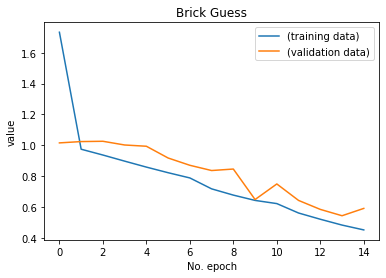

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot history: 
plt.plot(history.history['loss'], label='(training data)')
plt.plot(history.history['val_loss'], label='(validation data)')
plt.title('Brick Guess')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
plt.savefig('65pct.png')